In [77]:
import numpy as np
import pandas as pd
import operator as op

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

files_to_load = ['data/tlol/npz_short_data_0.npz']

# Load the NPZ dataset from all the files
dataset = np.concatenate([np.load(file) for file in files_to_load])
dataset

array(['classes', 'centerpoints', 'timestamps', 'healths', 'gameIds',
       'teamIds'], dtype='<U12')

In [3]:
# Get the required data from the dataset
gameIds = dataset["gameIds"] # Note: this is a byte array, not a float
# Replace gameIds with a unique integer for each game
allGameIds = np.unique(dataset["gameIds"])
gameIdsAsInts = np.arange(len(allGameIds))
gameIdMap = dict(zip(allGameIds, gameIdsAsInts))
gameIds = np.array(list(map(lambda x: gameIdMap[x], gameIds)))
teamIds = dataset["teamIds"]
classes = dataset["classes"]
timestamps = np.round(dataset["timestamps"], 1).astype(np.float32)
centerpoints = dataset["centerpoints"]
healths = dataset["healths"]

# Form a matrix of the required data
data = np.column_stack((gameIds, teamIds, classes, timestamps, centerpoints, healths))

In [5]:
filters = [
    [
        [3, op.gt, 7.5],
        [0, op.eq, 0]
    ]
]

parse_filter = lambda filter, data_to_filter: filter[1](data_to_filter[:, filter[0]], filter[2])


def get_column_filters(data_to_filter, filters_to_use):
    return [[parse_filter(filter, data_to_filter) for filter in filter_group] for filter_group in filters_to_use]


def filter_with_rules(data_to_filter, rules):
    mask = np.any([np.all(column_filter_group, axis=0) for column_filter_group in rules], axis=0)
    return data_to_filter[mask]

print(get_column_filters(data, filters))

matching_rows = filter_with_rules(data, get_column_filters(data, filters))

matching_rows

[[array([False, False, False, ...,  True,  True,  True]), array([ True,  True,  True, ..., False, False, False])]]


array([[0.0000000e+00, 1.0000000e+02, 0.0000000e+00, ..., 6.1200000e+02,
        6.0400000e+02, 6.4500000e+02],
       [0.0000000e+00, 1.0000000e+02, 0.0000000e+00, ..., 6.1200000e+02,
        6.0400000e+02, 6.4500000e+02],
       [0.0000000e+00, 1.0000000e+02, 0.0000000e+00, ..., 6.1200000e+02,
        6.0400000e+02, 6.4500000e+02],
       ...,
       [0.0000000e+00, 2.0000000e+02, 9.0000000e+00, ..., 1.9186270e+03,
        1.2347886e+04, 6.2119660e+02],
       [0.0000000e+00, 2.0000000e+02, 9.0000000e+00, ..., 1.8403383e+03,
        1.2331019e+04, 6.2178620e+02],
       [0.0000000e+00, 2.0000000e+02, 9.0000000e+00, ..., 1.8403383e+03,
        1.2331019e+04, 6.2178620e+02]])

In [6]:
from collections import defaultdict

entries = defaultdict(list)
for game in gameIdsAsInts[:5]:
    gameRows = data[data[:, 0] == game]
    for timestamp in np.unique(gameRows[:, 3]):
        timestampRows = gameRows[gameRows[:, 3] == timestamp]
        team = 100 #200
        teamRows = timestampRows[timestampRows[:, 1] == team]
        enemyRows = timestampRows[timestampRows[:, 1] != team]
        entry = np.concatenate((teamRows[:, 4:6].flatten(), enemyRows[:, 4:6].flatten()))
        entries[game].append(entry)


entries.keys()

dict_keys([0, 1, 2, 3, 4])

In [7]:
df = pd.DataFrame(entries.values()).T
a_single_player_single_game = [ row[0:2] for row in df[0]]
all_players_all_games = [ row[i:i+2] for j in range(5) for row in df[j] if row is not None for i in range(0, 10, 2)]

0  \
0    [612.0, 604.0, 436.0, 786.0, 136.0, 364.0, 402...   
1    [612.0, 604.0, 436.0, 786.0, 277.79147, 522.26...   
2    [612.0, 604.0, 401.88556, 646.6343, 344.98505,...   
3    [612.0, 604.0, 431.2839, 641.8046, 510.4234, 7...   
4    [612.0, 604.0, 420.449, 741.91693, 522.0, 772....   
..                                                 ...   
605  [13215.13, 3220.109, 7526.3213, 4916.0454, 738...   
606  [13215.13, 3220.109, 7509.483, 4832.654, 7352....   
607  [13264.32, 3288.4094, 7488.371, 4749.0273, 730...   
608  [13317.334, 3351.6865, 7467.0474, 4666.7314, 7...   
609  [13356.846, 3420.227, 7445.897, 4588.0493, 728...   

                                                     1  \
0    [402.0, 132.0, 612.0, 604.0, 286.0, 664.0, 398...   
1    [402.0, 132.0, 612.0, 604.0, 286.0, 664.0, 471...   
2    [402.0, 132.0, 612.0, 604.0, 286.0, 664.0, 580...   
3    [402.0, 132.0, 612.0, 604.0, 286.0, 664.0, 580...   
4    [402.0, 132.0, 612.0, 604.0, 286.0, 664.0, 580...   
..                                                 ...   
605                                               None   
606                                               None   
607                                               None   
608                                               None   
609                                               None   

                                                     2  \
0    [402.0, 132.0, 286.0, 664.0, 612.0, 604.0, 136...   
1    [402.0, 132.0, 448.0, 786.0, 612.0, 604.0, 136...   
2    [402.0, 132.0, 448.0, 786.0, 612.0, 604.0, 136...   
3    [402.0, 132.0, 448.0, 786.0, 612.0, 604.0, 273...   
4    [402.0, 132.0, 448.0, 786.0, 612.0, 604.0, 343...   
..                                                 ...   
605  [2882.0881, 12526.021, 5134.2617, 7343.9854, 1...   
606  [2932.2288, 12462.088, 5134.2617, 7343.9854, 1...   
607  [2866.128, 12427.558, 5134.2617, 7343.9854, 10...   
608  [2790.1147, 12398.859, 5134.2617, 7343.9854, 1...   
609                                               None   

                                                     3  \
0    [402.0, 132.0, 612.0, 604.0, 286.0, 664.0, 136...   
1    [402.0, 132.0, 468.0, 418.0, 286.0, 664.0, 136...   
2    [402.0, 132.0, 468.0, 418.0, 286.0, 664.0, 136...   
3    [402.0, 132.0, 420.0, 402.0, 286.0, 664.0, 136...   
4    [402.0, 132.0, 332.0, 396.0, 286.0, 664.0, 136...   
..                                                 ...   
605                                               None   
606                                               None   
607                                               None   
608                                               None   
609                                               None   

                                                     4  
0    [286.0, 664.0, 564.053, 180.72182, 311.92914, ...  
1    [286.0, 664.0, 708.0, 224.0, 511.1429, 444.269...  
2    [286.0, 664.0, 708.0, 224.0, 439.00494, 471.73...  
3    [286.0, 664.0, 708.0, 224.0, 375.7357, 385.763...  
4    [286.0, 664.0, 708.0, 224.0, 505.51776, 390.24...  
..                                                 ...  
605                                               None  
606                                               None  
607                                               None  
608                                               None  
609                                               None  

[610 rows x 5 columns]

In [10]:
def create_sequences(data, H, T):
    X, y = [], []
    for i in range(len(data) - H - T + 1):
        if i+H+T < len(data):
            X.append(data[i:i+H])  # Input sequence of length H
            y.append(data[i+H+T])  # Target sequence of length T
    return np.array(X), np.array(y)

X, y = create_sequences(a_single_player_single_game, 3, 1)

In [18]:
def split_data(X, y):
    indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=0.2, random_state=42, shuffle=False)
    X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten the input sequences
    X_test = X_test.reshape(X_test.shape[0], -1)
    return X_train, X_test, y_train, y_test, idx_train, idx_test

Mean Squared Error: 8786.04972945783
Root Mean Squared Error: 92.51881536345769
R-squared: 0.8547412877986547


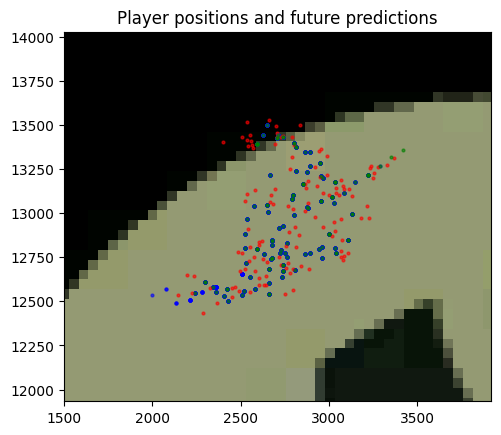

In [14]:
from numpy import single
from utils.compute_zoom_limits import compute_zoom_limits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_prediction_on_plot(plot, points, prediction, truth, map_image_path, zoom_range, options={}):
    """
    Plot the player positions on the map, and overlay the predicted and true future positions.

    Args:
    plot (matplotlib.pyplot): The plot to display the map on (can be a subplot or the main plot
    points (np.array): The player positions (x, y) at each time step
    prediction (np.array): The predicted future player positions (x, y)
    truth (np.array): The true future player positions (x, y)
    map_image_path (str): The path to the map image
    zoom_range (tuple): The x and y limits to zoom in to
    options (dict): Additional options for the plot:
        - figsize (tuple): The size of the plot
        - title (str): The title of the plot
        - inputPointsSize (int[]): Array of sizes for the input points
        - predictionPointsSize (int[]): Array of sizes for the prediction points
        - truthPointsSize (int[]): Array of sizes for the truth points
        - inputPointsColor (str[]): Array of colors for the input points
        - predictionPointsColor (str[]): Array of colors for the prediction points
        - truthPointsColor (str[]): Array of colors for the truth points
        - padding (int): The padding to add to the zoom range
    """

    # Get the options
    figsize = options.get('figsize', (10, 10))
    title = options.get('title', 'Player positions and future predictions')
    inputPointsSize = options.get('inputPointsSize', 2)
    predictionPointsSize = options.get('predictionPointsSize', 2)
    truthPointsSize = options.get('truthPointsSize', 2)
    inputPointsColor = options.get('inputPointsColor', 'blue')
    predictionPointsColor = options.get('predictionPointsColor', 'red')
    truthPointsColor = options.get('truthPointsColor', 'green')
    padding = options.get('padding', 500)

    # If plot is a subplot, clear
    if hasattr(plot, 'clear'):
        plot.clear()

    map_img = mpimg.imread(map_image_path)

    # Display image scaled to the variable
    plot.imshow(map_img, extent=[zoom_range[0][0], zoom_range[0][1], zoom_range[1][0], zoom_range[1][1]])

    # Overlay the player positions on the map
    for player_sequence in points:
        for i in range(1, len(player_sequence), 2):
            plot.plot(player_sequence[i], player_sequence[i-1], markersize=inputPointsSize, alpha=0.6, color=inputPointsColor, marker='o')

    for player in prediction:
        plot.plot(player[1], player[0], markersize=predictionPointsSize, alpha=0.6, color=predictionPointsColor, marker='o')

    for player in truth:
        plot.plot(player[1], player[0], markersize=truthPointsSize, alpha=0.6, color=truthPointsColor, marker='o')

    point_sequence_as_points = np.array([(point_sequence[i-1], point_sequence[i]) for point_sequence in points for i in range(1, len(point_sequence), 2)])

    all_points = np.concatenate((point_sequence_as_points, prediction, truth))
    # Zoom in to the center of the points
    smallest_y = np.min(all_points[:, 0])
    largest_y = np.max(all_points[:, 0])
    smallest_x = np.min(all_points[:, 1])
    largest_x = np.max(all_points[:, 1])
    
    # Set the limits of the plot differently for plot and subplot
    if hasattr(plot, 'gca'):
        plot = plot.gca()
    
    plot.set_xlim(smallest_x - padding, largest_x + padding)
    plot.set_ylim(smallest_y - padding, largest_y + padding)
    plot.set_title(title)

map_image_path = "assets/2x_2dlevelminimap.png"

# zoom_range = compute_zoom_limits(all_players_all_games, 0)
# print(zoom_range)
zoom_range = ((75, 14350), (75, 14350)) 

i = slice(0, 1000000)
plot_prediction_on_plot(plt, X_test[i], y_pred[i], y_test[i], map_image_path, zoom_range)

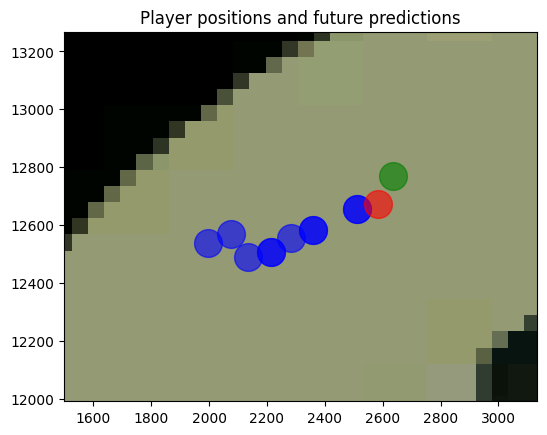

In [15]:
# Show the first 5 predictions in an animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def create_prediction_animation(points, prediction, truth, map_image_path, zoom_range, options={}):
    """
    Create an animation of the player positions and future predictions on the map.

    Args:
    points (np.array): The player positions (x, y) at each time step
    prediction (np.array): The predicted future player positions (x, y)
    truth (np.array): The true future player positions (x, y)
    map_image_path (str): The path to the map image
    zoom_range (tuple): The x and y limits to zoom in to
    options (dict): Additional options for the plot:
        - figsize (tuple): The size of the plot
        - title (str): The title of the plot
        - inputPointsSize (int[]): Array of sizes for the input points
        - predictionPointsSize (int[]): Array of sizes for the prediction points
        - truthPointsSize (int[]): Array of sizes for the truth points
        - inputPointsColor (str[]): Array of colors for the input points
        - predictionPointsColor (str[]): Array of colors for the prediction points
        - truthPointsColor (str[]): Array of colors for the truth points
        - padding (int): The padding to add to the zoom range
        - speed (int): The speed of the animation
    """
    fig, ax = plt.subplots()

    def update(frame):
        i = slice(frame, frame+1)
        ax.clear()
        plot_prediction_on_plot(ax, points[i], prediction[i], truth[i], map_image_path, zoom_range, options)        
    # Variable to control animation speed
    speed = options.get('speed', 1000)

    ani = FuncAnimation(fig, update, frames=range(len(X_test)), interval=speed, blit=False)
    return HTML(ani.to_jshtml())

options = {
    'speed': 500,
    'predictionPointsSize': 20,
    'truthPointsSize': 20,
    'inputPointsSize': 20,
}

create_prediction_animation(X_test, y_pred, y_test, map_image_path, zoom_range, options)



In [75]:
# Create a model that predicts the next position by taking a random step in the direction of the average velocity

class RandomStepModel:
    def __init__(self, H, T):
        self.H = H
        self.T = T

    def fit(self, X_train, y_train):
        pass

    def predict(self, X_test):
            # Unflatten X_test
            X_test = X_test.reshape(-1, self.H, 2)
            # Get average velocity for each sequence
            avg_velocity = (X_test[:, -1] - X_test[:, 0]) / self.H
            # Calculate the lenght of the step for timestep T
            step = avg_velocity * self.T
            # Calculate a random direction
            direction = np.random.uniform(-1, 1, size=step.shape)
            # Calculate the random step
            random_step = step * direction
            # Calculate the prediction
            y_pred = X_test[:, -1] + random_step
            return y_pred

# Create the model
H = 3
T = 1
random_step_model = RandomStepModel(H, T)

X_test, y_test = create_sequences(a_single_player_single_game, H, T)
X_test = X_test.reshape(X_test.shape[0], -1)

y_pred_random_walk = random_step_model.predict(X_test)
mse_random_walk = mean_squared_error(y_test, y_pred_random_walk)
rmse_random_walk = root_mean_squared_error(y_test, y_pred_random_walk)
r2_random_walk = r2_score(y_test, y_pred_random_walk)

print(f'Mean Squared Error (Random Walk): {mse_random_walk}')
print(f'Root Mean Squared Error (Random Walk): {rmse_random_walk}')
print(f'R-squared (Random Walk): {r2_random_walk}')

# Visualize the random walk predictions
#create_prediction_animation(X_test, y_pred_random_walk, y_test, map_image_path, zoom_range, options)

Mean Squared Error (Random Walk): 15244.050383643003
Root Mean Squared Error (Random Walk): 123.26711227680626
R-squared (Random Walk): 0.9982499746450495


In [64]:
# Create a model that selects the last position as the prediction

class LastPositionModel:
    def __init__(self, H):
        self.H = H


    def fit(self, X_train, y_train):
        pass

    def predict(self, X_test):
        # Unflatten X_test
        X_test = X_test.reshape(-1, self.H, 2)
        # Get the last position for each sequence
        return X_test[:, -1]
    
last_position_model = LastPositionModel(H)
last_position_model.fit(X_train, y_train)
y_pred_last_position = last_position_model.predict(X_test)
mse_last_position = mean_squared_error(y_test, y_pred_last_position)
rmse_last_position = root_mean_squared_error(y_test, y_pred_last_position)
r2_last_position = r2_score(y_test, y_pred_last_position)

print(f'Mean Squared Error (Last Position): {mse_last_position}')
print(f'Root Mean Squared Error (Last Position): {rmse_last_position}')
print(f'R-squared (Last Position): {r2_last_position}')

Mean Squared Error (Last Position): 16228523.2067074
Root Mean Squared Error (Last Position): 4025.887977384732
R-squared (Last Position): -0.33301698962553483


In [61]:
# Create a model that selects a random position from a given range as the prediction

class RandomPositionModel:
    def __init__(self, H, T, range_x, range_y):
        self.H = H
        self.range_x = range_x
        self.range_y = range_y

    def fit(self, X_train, y_train):
        pass

    def predict(self, X_test):
        # Unflatten X_test
        X_test = X_test.reshape(-1, self.H, 2)
        # Generate random positions for each sequence
        x = np.random.uniform(self.range_x[0], self.range_x[1], size=X_test.shape[0])
        y = np.random.uniform(self.range_y[0], self.range_y[1], size=X_test.shape[0])
        return np.column_stack((x, y))
range_x = (0, 15000)
range_y = (0, 15000)

random_position_model = RandomPositionModel(H, T, range_x, range_y)
random_position_model.fit(X_train, y_train)
y_pred_random_position = random_position_model.predict(X_test)
print(y_pred_random_position)
mse_random_position = mean_squared_error(y_test, y_pred_random_position)
rmse_random_position = root_mean_squared_error(y_test, y_pred_random_position)
r2_random_position = r2_score(y_test, y_pred_random_position)

print(f'Mean Squared Error (Random Position): {mse_random_position}')
print(f'Root Mean Squared Error (Random Position): {rmse_random_position}')
print(f'R-squared (Random Position): {r2_random_position}')

[[  708.72900084  4947.4223594 ]
 [14616.31669979  4241.36581029]
 [12836.95159194 12119.29877175]
 ...
 [13649.82826162 12175.54247946]
 [14046.0237761  10508.49852006]
 [  542.30836781 11517.74022559]]
Mean Squared Error (Random Position): 35015081.0213625
Root Mean Squared Error (Random Position): 5917.1468495500185
R-squared (Random Position): -1.8928894944478647


In [73]:
# Compare all four models

H_values = range(1, 100, 5)
T_values = range(1, 100, 5)

X, y = create_sequences(all_players_all_games, H, T)
X_train, X_test, y_train, y_test, _, _ = split_data(X, y)

linear_model = train_model(X_train, y_train)

results = {}


for H in H_values:
    for T in T_values:
        X, y = create_sequences(all_players_all_games, H, T)
        X_train, X_test, y_train, y_test, _, _ = split_data(X, y)
        models = {
            'Linear Model': LinearRegression(),
            'Random Step Model': RandomStepModel(H, T),
            'Last Position Model': LastPositionModel(H),
            'Random Position Model': RandomPositionModel(H, T, zoom_range[0], zoom_range[1])
        }
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            rmse = root_mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            results[(H, T, model_name)] = rmse

results_table = pd.DataFrame(results, index=['Root Mean Squared Error']).T
results_table.index.names = ['H', 'T', 'Model']
results_table = results_table.sort_index()
results_table

Root Mean Squared Error
H  T  Model                                         
1  1  Last Position Model                4025.887977
      Linear Model                       3764.330726
      Random Position Model              5683.893495
      Random Step Model                  4025.887977
   6  Last Position Model                4035.399969
...                                              ...
96 91 Random Step Model                  4312.590691
   96 Last Position Model                4145.613862
      Linear Model                       2331.350809
      Random Position Model              5675.075814
      Random Step Model                  4366.899362

[1600 rows x 1 columns]

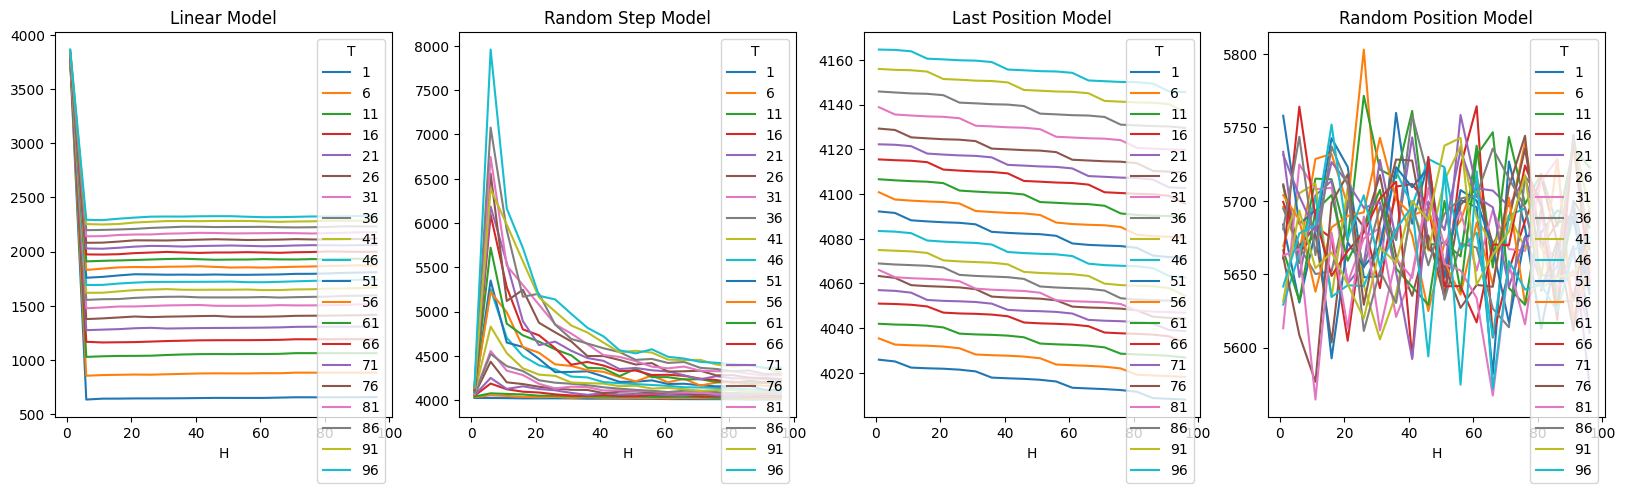

In [74]:
# Plot the results table
subplot_amount = len(models)

fig, ax = plt.subplots(1, subplot_amount, figsize=(20, 5))
for i, model_name in enumerate(models.keys()):
    results_table.xs(model_name, level='Model')['Root Mean Squared Error'].unstack().plot(ax=ax[i], title=model_name)

In [ ]:
# Plot distribution of errors for a model

